In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/cmi_inference_server.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/cmi_gateway.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/__init__.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/templates.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/base_gateway.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/relay.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/__init__.py
/kaggle/input/cmi-detect-behav

In [4]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
DATA_DIR = "/kaggle/input/cmi-detect-behavior-with-sensor-data/"
TRAIN_PATH = DATA_DIR + "train.csv"
TRAIN_DEMO_PATH = DATA_DIR + "train_demographics.csv"

train_df = pd.read_csv(TRAIN_PATH)
dem_df = pd.read_csv(TRAIN_DEMO_PATH)

In [11]:
print("Train shape:", train_df.shape)
train_df.head(5)

Train shape: (574945, 341)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
print("Demographics shape:", dem_df.shape)
dem_df.head(5)

Demographics shape: (81, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0


In [13]:
# Each sequence, get a unique gesture
gesture_counts = train_df[['sequence_id', 'gesture']].drop_duplicates().gesture.value_counts()
print("Number of unique gestures", gesture_counts.shape[0])
print(gesture_counts)

Number of unique gestures 18
gesture
Forehead - scratch                            640
Text on phone                                 640
Forehead - pull hairline                      640
Neck - scratch                                640
Neck - pinch skin                             640
Eyelash - pull hair                           640
Above ear - pull hair                         638
Eyebrow - pull hair                           638
Cheek - pinch skin                            637
Wave hello                                    478
Write name in air                             477
Pull air toward your face                     477
Feel around in tray and pull out an object    161
Write name on leg                             161
Pinch knee/leg skin                           161
Scratch knee/leg skin                         161
Drink from bottle/cup                         161
Glasses on/off                                161
Name: count, dtype: int64


In [17]:
# Acquire a unique gesture for each behavior and aggregate its distribution
behavior_counts = train_df[['sequence_id','behavior']].drop_duplicates().behavior.value_counts()
print("\nNumber of unique behaviors:", behavior_counts.shape[0])
print(behavior_counts)


Number of unique behaviors: 4
behavior
Hand at target location                      8151
Performs gesture                             8150
Moves hand to target location                4102
Relaxes and moves hand to target location    4049
Name: count, dtype: int64


In [18]:
#BFRB
seq_types = train_df[['sequence_id', 'sequence_type']].drop_duplicates().sequence_type.value_counts()
print("\nTarget/Non-Target Gesture:\n", seq_types)
print("Target(%) = {:.1f}%".format(100 * seq_types["Target"] / seq_types.sum()))


Target/Non-Target Gesture:
 sequence_type
Target        5113
Non-Target    3038
Name: count, dtype: int64
Target(%) = 62.7%


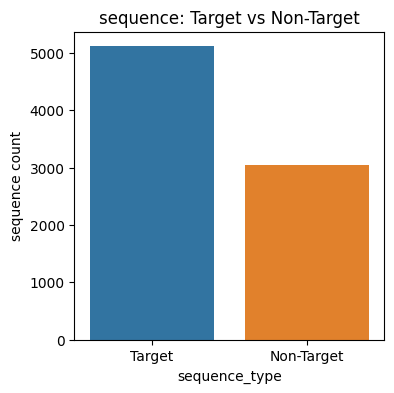

In [19]:
#Bar Chart Visualization (Target vs. Non-target)
plt.figure(figsize=(4,4))
sns.barplot(x=seq_types.index, y=seq_types.values)
plt.title("sequence: Target vs Non-Target")
plt.ylabel("sequence count")
plt.show()

count    8151.000000
mean       70.536744
std        35.389879
min        29.000000
25%        51.000000
50%        59.000000
75%        78.000000
max       700.000000
Name: sequence_counter, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


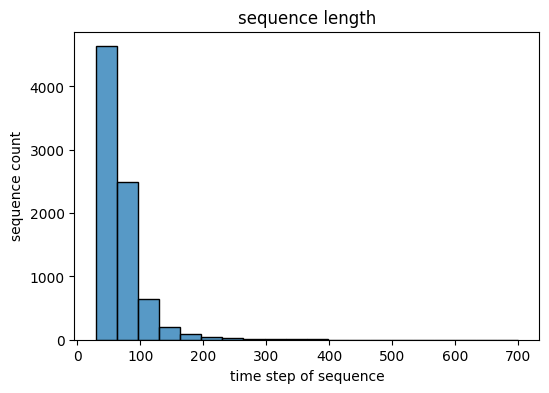

In [22]:
# Aggregate the sequence length
seq_lengths = train_df.groupby('sequence_id')['sequence_counter'].max() + 1  
print(seq_lengths.describe())
plt.figure(figsize=(6,4))
sns.histplot(seq_lengths, bins=20, kde=False)
plt.title("sequence length")
plt.xlabel("time step of sequence")
plt.ylabel("sequence count")
plt.show()


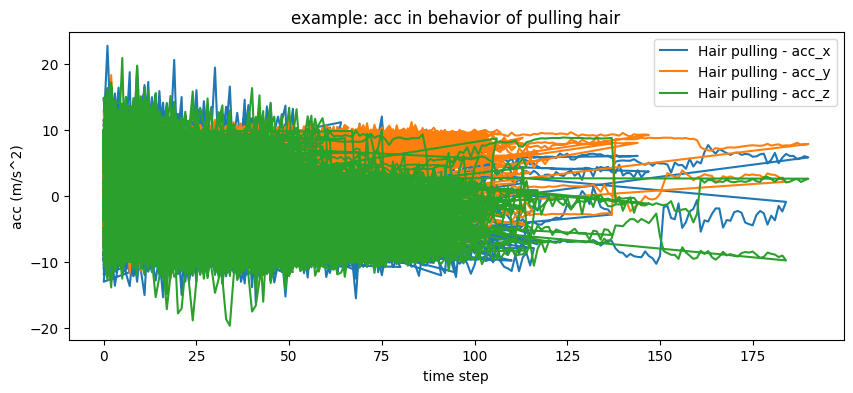

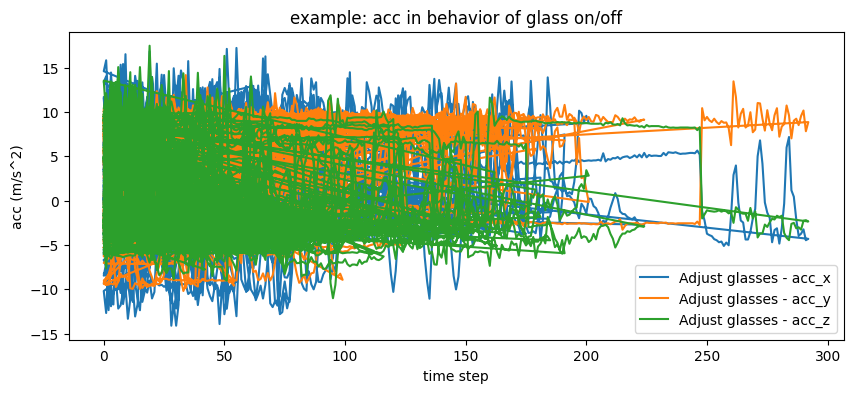

In [23]:
# As an example, extract one sequence each for a specific BFRB gesture and a non-BFRB gesture
example_bfrb = train_df[train_df['gesture'] == 'Above ear - pull hair']  # BFRB one
example_non = train_df[train_df['gesture'] == 'Glasses on/off']  # non-BFRB one

# Time series of acceleration
plt.figure(figsize=(10,4))
plt.plot(example_bfrb['sequence_counter'], example_bfrb['acc_x'], label='Hair pulling - acc_x')
plt.plot(example_bfrb['sequence_counter'], example_bfrb['acc_y'], label='Hair pulling - acc_y')
plt.plot(example_bfrb['sequence_counter'], example_bfrb['acc_z'], label='Hair pulling - acc_z')
plt.title("example: acc in behavior of pulling hair")
plt.xlabel("time step")
plt.ylabel("acc (m/s^2)")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(example_non['sequence_counter'], example_non['acc_x'], label='Adjust glasses - acc_x')
plt.plot(example_non['sequence_counter'], example_non['acc_y'], label='Adjust glasses - acc_y')
plt.plot(example_non['sequence_counter'], example_non['acc_z'], label='Adjust glasses - acc_z')
plt.title("example: acc in behavior of glass on/off")
plt.xlabel("time step")
plt.ylabel("acc (m/s^2)")
plt.legend()
plt.show()


In [24]:
# Calculation of missing value ratio
nan_ratio = train_df.isna().mean()  # NaN ratio for each column
nan_cols = nan_ratio[nan_ratio > 0]
print("Number of columns with missing values:", nan_cols.shape[0])
nan_cols.sort_values(ascending=False).head(20)

Number of columns with missing values: 329


thm_5        0.057894
tof_5_v63    0.052426
tof_5_v24    0.052426
tof_5_v18    0.052426
tof_5_v19    0.052426
tof_5_v20    0.052426
tof_5_v21    0.052426
tof_5_v22    0.052426
tof_5_v23    0.052426
tof_5_v25    0.052426
tof_5_v16    0.052426
tof_5_v26    0.052426
tof_5_v27    0.052426
tof_5_v28    0.052426
tof_5_v29    0.052426
tof_5_v30    0.052426
tof_5_v31    0.052426
tof_5_v17    0.052426
tof_5_v15    0.052426
tof_5_v33    0.052426
dtype: float64

In [25]:
# Number of adults/children and age distribution
print(dem_df['adult_child'].value_counts())
print("Age min, median, max:", dem_df['age'].min(), dem_df['age'].median(), dem_df['age'].max())

# Basic statistics for height and arm length
print(dem_df[['height_cm','shoulder_to_wrist_cm','elbow_to_wrist_cm']].describe())


adult_child
1    42
0    39
Name: count, dtype: int64
Age min, median, max: 10 22.0 53
        height_cm  shoulder_to_wrist_cm  elbow_to_wrist_cm
count   81.000000             81.000000          81.000000
mean   167.993827             51.580247          25.469136
std     10.605863              4.888415           3.025254
min    135.000000             41.000000          18.000000
25%    163.000000             49.000000          24.000000
50%    170.000000             52.000000          25.000000
75%    174.000000             55.000000          27.000000
max    190.500000             71.000000          44.000000


In [ ]:
# Preprocessing: Define a function to fill NaN values
def fill_na_values(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Fill Thermopile NaN with 0.0
    thm_cols = [c for c in df.columns if c.startswith('thm_')]
    df[thm_cols] = df[thm_cols].fillna(0.0)
    # Fill ToF NaN with -1
    tof_cols = [c for c in df.columns if c.startswith('tof_')]
    df[tof_cols] = df[tof_cols].fillna(-1)
    return df

# 1. Filter for the 'Performs gesture' phase
gesture_df = train_df[train_df['behavior'] == 'Performs gesture'].copy()
gesture_df = fill_na_values(gesture_df)

# 2. Aggregate by sequence -> Create a feature dataframe
features_list = []  # Add a feature dictionary for each sequence here
for seq_id, seq_data in gesture_df.groupby('sequence_id'):
    seq_feat = {"sequence_id": seq_id}
    # IMU features: mean and standard deviation of acc and rot
    for axis in ['acc_x','acc_y','acc_z','rot_w','rot_x','rot_y','rot_z']:
        seq_feat[f"{axis}_mean"] = seq_data[axis].mean()
        seq_feat[f"{axis}_std"]  = seq_data[axis].std()
    # Thermopile features: mean and max
    for i in range(1,6):
        col = f"thm_{i}"
        seq_feat[f"{col}_mean"] = seq_data[col].mean()
        seq_feat[f"{col}_max"]  = seq_data[col].max()
    # ToF features: min distance and detection rate
    for i in range(1,6):
        # Extract the 64 columns for the corresponding sensor
        tof_cols = [f"tof_{i}_v{j}" for j in range(64)]
        tof_vals = seq_data[tof_cols].values  # (sequence_length x 64) numpy array
        # To consider only valid detections, replace -1 with np.nan
        tof_vals_flat = tof_vals.flatten()
        tof_vals_flat = np.where(tof_vals_flat == -1, np.nan, tof_vals_flat)
        if np.all(np.isnan(tof_vals_flat)):
            # If there are no detections at all
            min_dist = 255  # Set min_dist to 255 for no detection (assuming 255 is a large value outside the normal range)
            detect_rate = 0.0
        else:
            min_dist = np.nanmin(tof_vals_flat)
            # Determine if there was at least one detection per frame
            frame_detect = np.any(np.isfinite(tof_vals), axis=1)  # True/False per time
            detect_rate = frame_detect.mean()
        seq_feat[f"tof_{i}_min_dist"] = min_dist
        seq_feat[f"tof_{i}_detect_rate"] = detect_rate
   # Add demographic information
subj = seq_data['subject'].iloc[0]
dem_row = dem_df[dem_df['subject'] == subj].iloc[0]
seq_feat["age"] = dem_row["age"]
seq_feat["sex"] = dem_row["sex"]
seq_feat["handedness"] = dem_row["handedness"]
seq_feat["height_cm"] = dem_row["height_cm"]
seq_feat["shoulder_to_wrist_cm"] = dem_row["shoulder_to_wrist_cm"]
seq_feat["elbow_to_wrist_cm"] = dem_row["elbow_to_wrist_cm"]
features_list.append(seq_feat)

train_features_df = pd.DataFrame(features_list)
print("Size of the feature dataframe:", train_features_df.shape)
train_features_df.head(5)

In [ ]:
# Add label columns (gesture name and sequence_type)
seq_labels = train_df[['sequence_id','gesture','sequence_type']].drop_duplicates(subset='sequence_id')
train_features_df = train_features_df.merge(seq_labels, on='sequence_id', how='left')
print("Size of feature data after joining with labels:", train_features_df.shape)
train_features_df[['sequence_id','gesture','sequence_type']].head(5)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

#Target/Non-Target
gesture_to_type = {row['gesture']: row['sequence_type'] for _, row in seq_labels.iterrows()}
target_gestures = [g for g,t in gesture_to_type.items() if t=="Target"]

# Build training data from the feature data
X = train_features_df.drop(columns=['sequence_id','gesture','sequence_type'])
y = train_features_df['gesture']  # multi-class label (18 classes)

# Split into groups by 'subject' to ensure subjects are not mixed
subjects = train_df[['sequence_id','subject']].drop_duplicates()['subject']
print(f"X: {X.shape}, y: {y.shape}, subjects: {subjects.shape}")

In [ ]:
X = X.fillna(0.0)
X.head(3)

In [ ]:
X.columns

In [ ]:
y.head(3)

In [ ]:
# Drop only the last row
subjects = subjects.iloc[:-1]
subjects.head(3)

In [ ]:
X_train, X_val, y_train, y_val, sub_train, sub_val = train_test_split(
    X, y, subjects, test_size=0.2, stratify=y, random_state=4)
print("Training data size:", X_train.shape, "Validation data size:", X_val.shape)

# Baseline model: Use only IMU features
imu_features = [c for c in X.columns if c.startswith('acc_') or c.startswith('rot_')]
clf_baseline = RandomForestClassifier(n_estimators=100, random_state=0)
clf_baseline.fit(X_train[imu_features], y_train)

# Predict on validation data
y_pred_base = clf_baseline.predict(X_val[imu_features])
print("Classification report for the baseline model:")
print(classification_report(y_val, y_pred_base, zero_division=0))

In [ ]:
# Calculate Binary F1 and Macro F1
# Based on the actual sequence_type (Target/Non-Target), map the predictions to Target/Non-Target as well
y_val_type = [gesture_to_type[g] for g in y_val]
y_pred_type = [gesture_to_type[g] for g in y_pred_base]
binary_f1 = f1_score(y_val_type, y_pred_type, pos_label="Target")

# Macro F1: Calculated across 9 classes in total (8 target classes + 1 Non-Target class)
y_val_macro = [g if gesture_to_type[g]=="Target" else "NonTarget" for g in y_val]
y_pred_macro = [g if gesture_to_type[g]=="Target" else "NonTarget" for g in y_pred_base]
labels = [g for g,t in gesture_to_type.items() if t=="Target"] + ["NonTarget"]
macro_f1 = f1_score(y_val_macro, y_pred_macro, labels=labels, average='macro')

print(f"Baseline model -> Binary F1 = {binary_f1:.3f}, Macro F1 = {macro_f1:.3f}, Average = {((binary_f1+macro_f1)/2):.3f}")


In [ ]:
# Improved model: Use all features (IMU+Thermo+ToF+Demographics)
clf_improved = RandomForestClassifier(n_estimators=100, random_state=0)
clf_improved.fit(X_train, y_train)
y_pred_imp = clf_improved.predict(X_val)

# Performance evaluation
print("Classification report for the improved model:")
print(classification_report(y_val, y_pred_imp, zero_division=0))
y_val_type = [gesture_to_type[g] for g in y_val]
y_pred_type = [gesture_to_type[g] for g in y_pred_imp]
binary_f1_imp = f1_score(y_val_type, y_pred_type, pos_label="Target")
y_val_macro = [g if gesture_to_type[g]=="Target" else "NonTarget" for g in y_val]
y_pred_macro = [g if gesture_to_type[g]=="Target" else "NonTarget" for g in y_pred_imp]
macro_f1_imp = f1_score(y_val_macro, y_pred_macro, labels=labels, average='macro')
print(f"Improved model -> Binary F1 = {binary_f1_imp:.3f}, Macro F1 = {macro_f1_imp:.3f}, Average = {((binary_f1_imp+macro_f1_imp)/2):.3f}")

In [ ]:
# Get and display top feature importances
importances = clf_improved.feature_importances_
feature_names = X.columns
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)
print("Top 10 features:\n", imp_df.head(10))

# Visualize with a bar graph
plt.figure(figsize=(8,5))
sns.barplot(x=imp_df.head(10)['importance'], y=imp_df.head(10)['feature'])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# Prepare the model and demographics globally for inference
model = clf_improved  # Use the trained model
dem_df_indexed = dem_df.set_index('subject')  # Index by subject ID for easy searching

def predict(sequence: pl.DataFrame, demographics: pl.DataFrame) -> str:
    seq_pd = sequence.to_pandas()

    # If phase information is available, extract the Gesture part; otherwise, use all rows
    if 'behavior' in seq_pd.columns:
        seq_pd = seq_pd[seq_pd['behavior'] == 'Performs gesture'].copy()
    elif 'phase' in seq_pd.columns:
        seq_pd = seq_pd[seq_pd['phase'] == 'Gesture'].copy()
    else:
        seq_pd = seq_pd.copy()

    if seq_pd.empty:
        raise ValueError("No usable rows found in the input sequence.")

    # Fill NaNs
    seq_pd = fill_na_values(seq_pd)

    feat = {}
    # IMU features
    for axis in ['acc_x','acc_y','acc_z','rot_w','rot_x','rot_y','rot_z']:
        feat[f"{axis}_mean"] = seq_pd[axis].mean()
        feat[f"{axis}_std"]  = seq_pd[axis].std()

    # Thermopile features
    for i in range(1, 6):
        col = f"thm_{i}"
        if seq_pd[col].isna().all():
            feat[f"{col}_mean"] = 26.0
            feat[f"{col}_max"] = 26.0
            continue
        feat[f"{col}_mean"] = seq_pd[col].mean()
        feat[f"{col}_max"] = seq_pd[col].max()

    # ToF features (process pixel-wise without flattening)
    for i in range(1, 6):
        tof_cols = [
            f"tof_{i}_v{j}" for j in range(64)
            if f"tof_{i}_v{j}" in seq_pd.columns
        ]
        if not tof_cols:
            feat[f"tof_{i}_mean_dist"] = 255.0
            feat[f"tof_{i}_min_dist"] = 255.0
            continue
        # If the tof_cols columns are all NaN
        if seq_pd[tof_cols].isna().all().all():
            feat[f"tof_{i}_mean_dist"] = 255.0
            feat[f"tof_{i}_min_dist"] = 255.0
            continue
        # Replace -1 with NaN
        vals = seq_pd[tof_cols].replace(-1, np.nan)
        feat[f"tof_{i}_mean_dist"] = vals.mean(skipna=True).mean()
        feat[f"tof_{i}_min_dist"] = vals.min(skipna=True).min()

    # Demographic features
    subj = seq_pd['subject'].iloc[0]
    if subj in dem_df_indexed.index:
        dem_row = dem_df_indexed.loc[subj]
        feat["age"] = dem_row["age"]
        feat["sex"] = dem_row["sex"]
        feat["handedness"] = dem_row["handedness"]
        feat["height_cm"] = dem_row["height_cm"]
        feat["shoulder_to_wrist_cm"] = dem_row["shoulder_to_wrist_cm"]
        feat["elbow_to_wrist_cm"] = dem_row["elbow_to_wrist_cm"]
    else:
        feat["age"] = dem_df["age"].mean()
        feat["sex"] = 1
        feat["handedness"] = 1
        feat["height_cm"] = dem_df["height_cm"].mean()
        feat["shoulder_to_wrist_cm"] = dem_df["shoulder_to_wrist_cm"].mean()
        feat["elbow_to_wrist_cm"] = dem_df["elbow_to_wrist_cm"].mean()

    # Reorder features to match the model's input
    X_seq = pd.DataFrame([feat])
    # Align features to the training order and fill missing columns with 0.0
    X_seq = X_seq.reindex(model.feature_names_in_, axis=1, fill_value=0.0)
    X_seq = X_seq.fillna(0.0)

    pred_gesture = model.predict(X_seq)[0]
    return pred_gesture

In [ ]:
import kaggle_evaluation.cmi_inference_server

inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        data_paths=(
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
        )
    )

In [ ]:
# test_df = pd.read_csv(DATA_DIR + "test.csv")
# test_demo_df = pd.read_csv(DATA_DIR + "test_demographics.csv")

In [ ]:
# print(test_df.shape)
# display(test_df.head(10))
# display(test_demo_df.head(5))

In [ ]:
# import polars as pl
# from tqdm import tqdm

# Get unique sequence_ids for inference
sequence_ids = test_df['sequence_id'].unique()

# For storing results
results = []

demo_pl = pl.from_pandas(test_demo_df)

# Infer one sequence at a time
for seq_id in tqdm(sequence_ids):
    # Convert the data for the corresponding sequence to Polars
    seq_df = test_df[test_df["sequence_id"] == seq_id]
    seq_pl = pl.from_pandas(seq_df)

    try:
        gesture = predict(seq_pl, demo_pl)
        print(gesture)
        results.append((seq_id, gesture))
    except Exception as e:
        print(f"Error for {seq_id}: {e}")
        results.append((seq_id, "ERROR"))

In [ ]:
# pred_df = pd.DataFrame(results, columns=["sequence_id", "gesture"])
# pred_df.head()

In [ ]:
# res = pd.read_parquet("/kaggle/working/submission.parquet")
# res.head(10)

In [ ]:
# test_seq_id = test_df["sequence_id"].iloc[0]

# 2. Extract and copy that sequence
seq_masked = test_df[test_df["sequence_id"] == test_seq_id].copy()

# 3. Mask Thermopile / ToF columns with NaN
non_imu_cols = [c for c in seq_masked.columns
                if c.startswith("thm_") or c.startswith("tof_")]
seq_masked[non_imu_cols] = np.nan

# 4. Convert to Polars (since predict accepts a pl.DataFrame)
seq_pl  = pl.from_pandas(seq_masked)
demo_pl = pl.from_pandas(test_demo_df)

display(seq_pl.head(3))
display(demo_pl.head(3))

# 5. Call the predict function
pred_gesture = predict(seq_pl, demo_pl)
print(f"sequence_id: {test_seq_id}  →  predicted gesture = {pred_gesture}")